The goal of this notebook is to load pre-processed carbon stock datasets, standardize units and spatial resolution, and mosaic together into layers that provide wall-to-wall carbon stock metrics for the y2y region.

In [1]:
# load packages
import geopandas as gpd
import rasterio
from rasterio.warp import Resampling
import rioxarray as rxr
import xarray as xr
from rioxarray.merge import merge_arrays
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# define print raster function to help compare reprojections
def print_raster(raster):
    print(
        f"shape: {raster.rio.shape}\n"
        f"resolution: {raster.rio.resolution()}\n"
        f"bounds: {raster.rio.bounds()}\n"
        f"sum: {raster.sum().item()}\n"
        f"CRS: {raster.rio.crs}\n"
        f"NoDataValue: {raster.rio.nodata}\n"
        f"NoDataOriginalValues: {raster.rio.encoded_nodata}\n"
    )

### The first map is a combination of Sothe forest carbon canada layers and Spawn agb/bgb Forest Carbon Stock layers along with corresponding uncertainty values

In [3]:
# set clipped layers directory
carbon_dir = './carbon_stock_data/final_layers_clipped'

# set Sothe carbon stock layers filepaths
carbon_sothe_dir = carbon_dir + '/forest_carbon_kg_m2_sothe.tif'
carbon_err_sothe_dir = carbon_dir + '/forest_carbon_uncertainty_kg_m2_sothe.tif'

# set spawn carbon stock layers filepaths
agb_spawn_dir = carbon_dir + '/agb_mg_ha_spawn_2010.tif'
bgb_spawn_dir = carbon_dir + '/bgb_mg_ha_spawn_2010.tif'
agb_err_spawn_dir = carbon_dir + '/agb_uncertainty_mg_ha_spawn_2010.tif'
bgb_err_spawn_dir = carbon_dir + '/bgb_uncertainty_mg_ha_spawn_2010.tif'

In [4]:
# load data arrays
carbon_sothe = xr.open_dataarray(carbon_sothe_dir)
carbon_err_sothe = xr.open_dataarray(carbon_err_sothe_dir)
agb_spawn = xr.open_dataarray(agb_spawn_dir)
bgb_spawn = xr.open_dataarray(bgb_spawn_dir)
agb_err_spawn = xr.open_dataarray(agb_err_spawn_dir)
bgb_err_spawn = xr.open_dataarray(bgb_err_spawn_dir)

In [5]:
# print attributes
print_raster(carbon_sothe)
print_raster(carbon_err_sothe)
print_raster(agb_spawn)
print_raster(agb_err_spawn)

shape: (11385, 14576)
resolution: (0.00224599624135848, -0.0022459534258844607)
bounds: (-141.03574267575004, 41.75148751365874, -108.29810146170884, 67.32166726735333)
sum: 100289472.0
CRS: EPSG:4326
NoDataValue: nan
NoDataOriginalValues: -3.4028234663852886e+38

shape: (11385, 14576)
resolution: (0.00224599624135848, -0.0022459534258844607)
bounds: (-141.03574267575004, 41.75148751365874, -108.29810146170884, 67.32166726735333)
sum: 61229756.0
CRS: EPSG:4326
NoDataValue: nan
NoDataOriginalValues: -3.4028234663852886e+38

shape: (9206, 11785)
resolution: (0.002777777777777999, -0.002777777777778)
bounds: (-141.03611111111087, 41.750000000000064, -108.29999999999715, 67.32222222222433)
sum: 8712377344.0
CRS: EPSG:4326
NoDataValue: nan
NoDataOriginalValues: 65536.0

shape: (9206, 11785)
resolution: (0.002777777777777999, -0.002777777777778)
bounds: (-141.03611111111087, 41.750000000000064, -108.29999999999715, 67.32222222222433)
sum: 3614690048.0
CRS: EPSG:4326
NoDataValue: nan
NoDataOr

First we add the two spawn layers together, for a total biomass carbon layer. The agb and bgb layers can be added directly, and the standard error layers added together using summation in quadrature. For adding cells together, we square the errors, add them together, and take the sqrt.

In [6]:
# add spawn agb and bgb together
carbon_spawn = agb_spawn + bgb_spawn
carbon_spawn.rio.write_nodata(np.nan, encoded=True, inplace=True) # reset nodata attr since gets lost

# add spawn agb and bgb standard errors together
carbon_err_spawn = xr.ufuncs.sqrt((agb_err_spawn ** 2) + (bgb_err_spawn ** 2))
carbon_err_spawn.rio.write_nodata(np.nan, encoded=True, inplace=True)

# print attributes
print_raster(carbon_spawn)
print_raster(carbon_err_spawn)

shape: (9206, 11785)
resolution: (0.002777777777777999, -0.002777777777778)
bounds: (-141.03611111111087, 41.750000000000064, -108.29999999999715, 67.32222222222433)
sum: 12312211456.0
CRS: EPSG:4326
NoDataValue: nan
NoDataOriginalValues: nan

shape: (9206, 11785)
resolution: (0.002777777777777999, -0.002777777777778)
bounds: (-141.03611111111087, 41.750000000000064, -108.29999999999715, 67.32222222222433)
sum: 4400961536.0
CRS: EPSG:4326
NoDataValue: nan
NoDataOriginalValues: nan



Next we reproject the Sothe carbon layer to match the resolution of the Spawn layer.

In [7]:
# reproject sothe to match spawn projection and resolution
# resample taking the average
# pixels resampling where 50% or more of samples are nan will be set as nan
carbon_sothe_reproj = carbon_sothe.rio.reproject_match(carbon_spawn, resampling=Resampling.average, NODATA_VALUES_PCT_THRESHOLD=50)

# assign coords to make coordinates the exact same (can be tiny differences)
carbon_sothe_reproj = carbon_sothe_reproj.assign_coords({
    "x": carbon_spawn.x,
    "y": carbon_spawn.y,
})

# print attributes
print_raster(carbon_sothe_reproj)
print_raster(carbon_spawn)

shape: (9206, 11785)
resolution: (0.002777777777777999, -0.002777777777778)
bounds: (-141.03611111111087, 41.750000000000064, -108.29999999999715, 67.32222222222433)
sum: 66024460.0
CRS: EPSG:4326
NoDataValue: nan
NoDataOriginalValues: -3.4028234663852886e+38

shape: (9206, 11785)
resolution: (0.002777777777777999, -0.002777777777778)
bounds: (-141.03611111111087, 41.750000000000064, -108.29999999999715, 67.32222222222433)
sum: 12312211456.0
CRS: EPSG:4326
NoDataValue: nan
NoDataOriginalValues: nan



And we also need to reproject the Sothe uncertainty layer. For the carbon layer above, we can simply reproject by taking the weighted average of the values. For the uncertainty layer, we first need to convert the values to standard error to match the Spawn uncertainty layer. Since the Sothe uncertainty layer is the difference between the 0.95 and 0.05 quantile of the prediction interval, we can divide it by two to get the +- of the 90th percentile prediction interval. Based on the central limit theorem, we can use a normal distribution to then calculate the standard error, which is calculated by dividing that number by 1.645.

Once we have the standard error, we square the values, resample taking the area-weighted average, and take the square root to end up with the standard error.

In [8]:
# calculate the standard error of the sothe uncertainty layer and take the square
carbon_se2_sothe = ((carbon_err_sothe / 2) / 1.645) ** 2
carbon_se2_sothe.rio.write_nodata(np.nan, encoded=True, inplace=True)


# reproject the square of the sothe standard error to match spawn projection and resolution
# resample taking the average
# pixels resampling where 50% or more of samples are nan will be set as nan
# take the square root of the output
carbon_err_sothe_reproj = xr.ufuncs.sqrt(carbon_se2_sothe.rio.reproject_match(carbon_spawn, resampling=Resampling.average, NODATA_VALUES_PCT_THRESHOLD=50))
carbon_err_sothe_reproj.rio.write_nodata(np.nan, encoded=True, inplace=True)

# assign coords to make coordinates the exact same (can be tiny differences)
carbon_err_sothe_reproj = carbon_err_sothe_reproj.assign_coords({
    "x": carbon_spawn.x,
    "y": carbon_spawn.y,
})

# print attributes
print_raster(carbon_err_sothe_reproj)
print_raster(carbon_sothe_reproj)
print_raster(carbon_spawn)

shape: (9206, 11785)
resolution: (0.002777777777777999, -0.002777777777778)
bounds: (-141.03611111111087, 41.750000000000064, -108.29999999999715, 67.32222222222433)
sum: 12321168.0
CRS: EPSG:4326
NoDataValue: nan
NoDataOriginalValues: nan

shape: (9206, 11785)
resolution: (0.002777777777777999, -0.002777777777778)
bounds: (-141.03611111111087, 41.750000000000064, -108.29999999999715, 67.32222222222433)
sum: 66024460.0
CRS: EPSG:4326
NoDataValue: nan
NoDataOriginalValues: -3.4028234663852886e+38

shape: (9206, 11785)
resolution: (0.002777777777777999, -0.002777777777778)
bounds: (-141.03611111111087, 41.750000000000064, -108.29999999999715, 67.32222222222433)
sum: 12312211456.0
CRS: EPSG:4326
NoDataValue: nan
NoDataOriginalValues: nan



In [9]:
# # plot the three
# fig, axes = plt.subplots(ncols=3, figsize=(12,4))
# carbon_err_sothe_reproj.plot(ax=axes[0])
# carbon_sothe_reproj.plot(ax=axes[1])
# carbon_spawn.plot(ax=axes[2])
# plt.draw()

In [10]:
# convert sothe layers to t/ha
carbon_sothe_reproj_t_ha = carbon_sothe_reproj * 10
carbon_sothe_reproj_t_ha.rio.write_nodata(np.nan, encoded=True, inplace=True)
carbon_err_sothe_reproj_t_ha = carbon_err_sothe_reproj * 10
carbon_err_sothe_reproj_t_ha.rio.write_nodata(np.nan, encoded=True, inplace=True)
print_raster(carbon_sothe_reproj_t_ha)
print_raster(carbon_err_sothe_reproj_t_ha)

# convert spawn layers to t/ha
carbon_spawn_t_ha = carbon_spawn * 0.1
carbon_spawn_t_ha.rio.write_nodata(np.nan, encoded=True, inplace=True)
carbon_err_spawn_t_ha = carbon_err_spawn * 0.1
carbon_err_spawn_t_ha.rio.write_nodata(np.nan, encoded=True, inplace=True)
print_raster(carbon_spawn_t_ha)
print_raster(carbon_err_spawn_t_ha)

shape: (9206, 11785)
resolution: (0.002777777777777999, -0.002777777777778)
bounds: (-141.03611111111087, 41.750000000000064, -108.29999999999715, 67.32222222222433)
sum: 660243968.0
CRS: EPSG:4326
NoDataValue: nan
NoDataOriginalValues: nan

shape: (9206, 11785)
resolution: (0.002777777777777999, -0.002777777777778)
bounds: (-141.03611111111087, 41.750000000000064, -108.29999999999715, 67.32222222222433)
sum: 123211480.0
CRS: EPSG:4326
NoDataValue: nan
NoDataOriginalValues: nan

shape: (9206, 11785)
resolution: (0.002777777777777999, -0.002777777777778)
bounds: (-141.03611111111087, 41.750000000000064, -108.29999999999715, 67.32222222222433)
sum: 1231221504.0
CRS: EPSG:4326
NoDataValue: nan
NoDataOriginalValues: nan

shape: (9206, 11785)
resolution: (0.002777777777777999, -0.002777777777778)
bounds: (-141.03611111111087, 41.750000000000064, -108.29999999999715, 67.32222222222433)
sum: 440094176.0
CRS: EPSG:4326
NoDataValue: nan
NoDataOriginalValues: nan



In [11]:
# combine datasets, defaulting to Sothe values
carbon_t_ha = carbon_sothe_reproj_t_ha.combine_first(carbon_spawn_t_ha)
carbon_err_t_ha = carbon_err_sothe_reproj_t_ha.combine_first(carbon_err_spawn_t_ha)

carbon_t_ha.rio.write_nodata(np.nan, encoded=True, inplace=True)
carbon_err_t_ha.rio.write_nodata(np.nan, encoded=True, inplace=True)

print_raster(carbon_t_ha)
print_raster(carbon_err_t_ha)

shape: (9206, 11785)
resolution: (0.002777777777777999, -0.002777777777778)
bounds: (-141.03611111111087, 41.750000000000064, -108.29999999999715, 67.32222222222433)
sum: 1017631680.0
CRS: EPSG:4326
NoDataValue: nan
NoDataOriginalValues: nan

shape: (9206, 11785)
resolution: (0.002777777777777999, -0.002777777777778)
bounds: (-141.03611111111087, 41.750000000000064, -108.29999999999715, 67.32222222222433)
sum: 310738336.0
CRS: EPSG:4326
NoDataValue: nan
NoDataOriginalValues: nan



In [12]:
# # plot the two
# fig, axes = plt.subplots(ncols=2, figsize=(12,4))
# carbon_t_ha.plot(ax=axes[0])
# carbon_err_t_ha.plot(ax=axes[1])
# plt.draw()

In [13]:
# round values to one decimal
carbon_t_ha = carbon_t_ha.round(1)
carbon_err_t_ha = carbon_err_t_ha.round(1)
carbon_t_ha.rio.write_nodata(np.nan, encoded=True, inplace=True)
carbon_err_t_ha.rio.write_nodata(np.nan, encoded=True, inplace=True)

print_raster(carbon_t_ha)
print_raster(carbon_err_t_ha)

shape: (9206, 11785)
resolution: (0.002777777777777999, -0.002777777777778)
bounds: (-141.03611111111087, 41.750000000000064, -108.29999999999715, 67.32222222222433)
sum: 1017630848.0
CRS: EPSG:4326
NoDataValue: nan
NoDataOriginalValues: nan

shape: (9206, 11785)
resolution: (0.002777777777777999, -0.002777777777778)
bounds: (-141.03611111111087, 41.750000000000064, -108.29999999999715, 67.32222222222433)
sum: 310644736.0
CRS: EPSG:4326
NoDataValue: nan
NoDataOriginalValues: nan



In [14]:
# export raster
carbon_t_ha.rio.to_raster('./carbon_stock_data/output_layers/carbon_sothe_spawn_t_ha.tif')
carbon_err_t_ha.rio.to_raster('./carbon_stock_data/output_layers/carbon_err_sothe_spawn_t_ha.tif')

### The Second map is aboveground and belowground carbon stock from Spawn 2010

In [15]:
# load file path
carbon_dir = './carbon_stock_data/final_layers_clipped'

agb_spawn_dir = carbon_dir + '/agb_mg_ha_spawn_2010.tif'
bgb_spawn_dir = carbon_dir + '/bgb_mg_ha_spawn_2010.tif'
agb_err_spawn_dir = carbon_dir + '/agb_uncertainty_mg_ha_spawn_2010.tif'
bgb_err_spawn_dir = carbon_dir + '/bgb_uncertainty_mg_ha_spawn_2010.tif'

In [16]:
# load data arrays
agb_spawn = xr.open_dataarray(agb_spawn_dir)
bgb_spawn = xr.open_dataarray(bgb_spawn_dir)
agb_err_spawn = xr.open_dataarray(agb_spawn_dir)
bgb_err_spawn = xr.open_dataarray(bgb_spawn_dir)

In [17]:
# check attributes
print_raster(agb_spawn)
print_raster(bgb_spawn)
print_raster(agb_err_spawn)
print_raster(bgb_err_spawn)

shape: (9206, 11785)
resolution: (0.002777777777777999, -0.002777777777778)
bounds: (-141.03611111111087, 41.750000000000064, -108.29999999999715, 67.32222222222433)
sum: 8712377344.0
CRS: EPSG:4326
NoDataValue: nan
NoDataOriginalValues: 65536.0

shape: (9206, 11785)
resolution: (0.002777777777777999, -0.002777777777778)
bounds: (-141.03611111111087, 41.750000000000064, -108.29999999999715, 67.32222222222433)
sum: 3599774464.0
CRS: EPSG:4326
NoDataValue: nan
NoDataOriginalValues: 65536.0

shape: (9206, 11785)
resolution: (0.002777777777777999, -0.002777777777778)
bounds: (-141.03611111111087, 41.750000000000064, -108.29999999999715, 67.32222222222433)
sum: 8712377344.0
CRS: EPSG:4326
NoDataValue: nan
NoDataOriginalValues: 65536.0

shape: (9206, 11785)
resolution: (0.002777777777777999, -0.002777777777778)
bounds: (-141.03611111111087, 41.750000000000064, -108.29999999999715, 67.32222222222433)
sum: 3599774464.0
CRS: EPSG:4326
NoDataValue: nan
NoDataOriginalValues: 65536.0



In [18]:
# convert to t/ha
agb_spawn_t_ha = agb_spawn * 0.1
bgb_spawn_t_ha = bgb_spawn * 0.1
agb_err_spawn_t_ha = agb_err_spawn * 0.1
bgb_err_spawn_t_ha = bgb_err_spawn * 0.1

# write no data values into metadata
agb_spawn_t_ha.rio.write_nodata(np.nan, encoded=True, inplace=True)
bgb_spawn_t_ha.rio.write_nodata(np.nan, encoded=True, inplace=True)
agb_err_spawn_t_ha.rio.write_nodata(np.nan, encoded=True, inplace=True)
bgb_err_spawn_t_ha.rio.write_nodata(np.nan, encoded=True, inplace=True)
print_raster(agb_spawn_t_ha)
print_raster(bgb_spawn_t_ha)
print_raster(agb_err_spawn_t_ha)
print_raster(bgb_err_spawn_t_ha)

shape: (9206, 11785)
resolution: (0.002777777777777999, -0.002777777777778)
bounds: (-141.03611111111087, 41.750000000000064, -108.29999999999715, 67.32222222222433)
sum: 871243200.0
CRS: EPSG:4326
NoDataValue: nan
NoDataOriginalValues: nan

shape: (9206, 11785)
resolution: (0.002777777777777999, -0.002777777777778)
bounds: (-141.03611111111087, 41.750000000000064, -108.29999999999715, 67.32222222222433)
sum: 359978112.0
CRS: EPSG:4326
NoDataValue: nan
NoDataOriginalValues: nan

shape: (9206, 11785)
resolution: (0.002777777777777999, -0.002777777777778)
bounds: (-141.03611111111087, 41.750000000000064, -108.29999999999715, 67.32222222222433)
sum: 871243200.0
CRS: EPSG:4326
NoDataValue: nan
NoDataOriginalValues: nan

shape: (9206, 11785)
resolution: (0.002777777777777999, -0.002777777777778)
bounds: (-141.03611111111087, 41.750000000000064, -108.29999999999715, 67.32222222222433)
sum: 359978112.0
CRS: EPSG:4326
NoDataValue: nan
NoDataOriginalValues: nan



In [19]:
# export final layers
agb_spawn_t_ha.rio.to_raster('./carbon_stock_data/output_layers/agb_spawn_t_ha.tif')
bgb_spawn_t_ha.rio.to_raster('./carbon_stock_data/output_layers/bgb_spawn_t_ha.tif')
agb_err_spawn_t_ha.rio.to_raster('./carbon_stock_data/output_layers/agb_err_spawn_t_ha.tif')
bgb_err_spawn_t_ha.rio.to_raster('./carbon_stock_data/output_layers/bgb_err_spawn_t_ha.tif')

### The Soil Organic Carbon Map is a combination of Sothe Canada data (0-1m depth), soilgrids data (0-30 cm depth) and openlandmap data (30-100 cm depth)

In [20]:
# load file path
carbon_dir = './carbon_stock_data/final_layers_clipped'

soc_sothe_dir = carbon_dir + '/soc_0_1m_kg_m2_sothe.tif'
soc_err_sothe_dir = carbon_dir + '/soc_uncertainty_0_1m_kg_m2_sothe.tif'

soc_soilgrids_0_30_dir = carbon_dir + '/soc_mean_0_30cm_t_ha_soilgrids.tif'
soc_q05_soilgrids_0_30_dir = carbon_dir + '/soc_q05_0_30cm_t_ha_soilgrids.tif'
soc_q95_soilgrids_0_30_dir = carbon_dir + '/soc_q95_0_30cm_t_ha_soilgrids.tif'

soc_olm_30_100_dir = carbon_dir + '/soc_30_100cm_kg_m2_openlandmap.tif'

In [21]:
# load data arrays
soc_sothe = xr.open_dataarray(soc_sothe_dir)
soc_err_sothe = xr.open_dataarray(soc_err_sothe_dir)

soc_soilgrids_0_30 = xr.open_dataarray(soc_soilgrids_0_30_dir)
soc_q05_soilgrids_0_30 = xr.open_dataarray(soc_q05_soilgrids_0_30_dir)
soc_q95_soilgrids_0_30 = xr.open_dataarray(soc_q95_soilgrids_0_30_dir)

soc_olm_30_100 = xr.open_dataarray(soc_olm_30_100_dir)

In [22]:
# print attributes
print_raster(soc_sothe)
print_raster(soc_soilgrids_0_30)
print_raster(soc_olm_30_100)

shape: (11386, 14570)
resolution: (0.002245789848076825, -0.0022457903991559692)
bounds: (-141.01985, 41.75143371197468, -108.29869191352066, 67.32200319676454)
sum: 762864064.0
CRS: EPSG:4326
NoDataValue: nan
NoDataOriginalValues: 0.0

shape: (10247, 6870)
resolution: (249.9875719002335, -250.0098673320364)
bounds: (-13538208.38001439, 4647455.575617532, -11820793.761059787, 7209306.68616891)
sum: 1344991360.0
CRS: PROJCS["Interrupted_Goode_Homolosine",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["Degree",0.0174532925199433]],PROJECTION["Interrupted_Goode_Homolosine"],PARAMETER["central_meridian",0],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]
NoDataValue: nan
NoDataOriginalValues: -9999.0

shape: (12274, 15713)
resolution: (0.0020833330000000006, -0.002083333)
bounds: (-141.035422

First we need to reproject the layers. We will reproject all layers to match the Spawn layers for consistency. Similarly to the biomass carbon layers, we need to calculate the Sothe and soilgrids standard error so that we can apply summation in quadrature to the reprojection. To do so, we take the difference between the q95 and q05 layers (this is already the Sothe uncertainty layer), divide by two, and further divide by 1.645 (central limit theorem dictating a normal distribution of values surrounding the mean).

In [23]:
# reproject sothe to match spawn projection and resolution
# resample taking the average
# pixels resampling where 50% or more of samples are nan will be set as nan
soc_sothe_reproj = soc_sothe.rio.reproject_match(carbon_spawn, resampling=Resampling.average, NODATA_VALUES_PCT_THRESHOLD=50)

# assign coords to make coordinates the exact same (can be tiny differences)
soc_sothe_reproj = soc_sothe_reproj.assign_coords({
    "x": carbon_spawn.x,
    "y": carbon_spawn.y,
})

# print attributes
print_raster(soc_sothe_reproj)
print_raster(carbon_spawn)

shape: (9206, 11785)
resolution: (0.002777777777777999, -0.002777777777778)
bounds: (-141.03611111111087, 41.750000000000064, -108.29999999999715, 67.32222222222433)
sum: 500122016.0
CRS: EPSG:4326
NoDataValue: nan
NoDataOriginalValues: 0.0

shape: (9206, 11785)
resolution: (0.002777777777777999, -0.002777777777778)
bounds: (-141.03611111111087, 41.750000000000064, -108.29999999999715, 67.32222222222433)
sum: 12312211456.0
CRS: EPSG:4326
NoDataValue: nan
NoDataOriginalValues: nan



In [24]:
# calculate the standard error of the sothe uncertainty layer and take the square
soc_se2_sothe = ((soc_err_sothe / 2) / 1.645) ** 2
soc_se2_sothe.rio.write_nodata(np.nan, encoded=True, inplace=True)

# reproject the square of the sothe standard error to match spawn projection and resolution
# resample taking the average
# pixels resampling where 50% or more of samples are nan will be set as nan
# take the square root of the output
soc_err_sothe_reproj = xr.ufuncs.sqrt(soc_se2_sothe.rio.reproject_match(carbon_spawn, resampling=Resampling.average, NODATA_VALUES_PCT_THRESHOLD=50))
soc_err_sothe_reproj.rio.write_nodata(np.nan, encoded=True, inplace=True)

# assign coords to make coordinates the exact same (can be tiny differences)
soc_err_sothe_reproj = soc_err_sothe_reproj.assign_coords({
    "x": carbon_spawn.x,
    "y": carbon_spawn.y,
})

# print attributes
print_raster(soc_err_sothe_reproj)
print_raster(soc_sothe_reproj)
print_raster(carbon_spawn)

shape: (9206, 11785)
resolution: (0.002777777777777999, -0.002777777777778)
bounds: (-141.03611111111087, 41.750000000000064, -108.29999999999715, 67.32222222222433)
sum: 222714000.0
CRS: EPSG:4326
NoDataValue: nan
NoDataOriginalValues: nan

shape: (9206, 11785)
resolution: (0.002777777777777999, -0.002777777777778)
bounds: (-141.03611111111087, 41.750000000000064, -108.29999999999715, 67.32222222222433)
sum: 500122016.0
CRS: EPSG:4326
NoDataValue: nan
NoDataOriginalValues: 0.0

shape: (9206, 11785)
resolution: (0.002777777777777999, -0.002777777777778)
bounds: (-141.03611111111087, 41.750000000000064, -108.29999999999715, 67.32222222222433)
sum: 12312211456.0
CRS: EPSG:4326
NoDataValue: nan
NoDataOriginalValues: nan



In [25]:
# reproject soilgrids to match spawn projection and resolution
# resample taking the average
# pixels resampling where 50% or more of samples are nan will be set as nan
soc_soilgrids_0_30_reproj = soc_soilgrids_0_30.rio.reproject_match(carbon_spawn, resampling=Resampling.average, NODATA_VALUES_PCT_THRESHOLD=50)

# assign coords to make coordinates the exact same (can be tiny differences)
soc_soilgrids_0_30_reproj = soc_soilgrids_0_30_reproj.assign_coords({
    "x": carbon_spawn.x,
    "y": carbon_spawn.y,
})

# print attributes
print_raster(soc_soilgrids_0_30_reproj)
print_raster(carbon_spawn)

shape: (9206, 11785)
resolution: (0.002777777777777999, -0.002777777777778)
bounds: (-141.03611111111087, 41.750000000000064, -108.29999999999715, 67.32222222222433)
sum: 1633580672.0
CRS: EPSG:4326
NoDataValue: nan
NoDataOriginalValues: -9999.0

shape: (9206, 11785)
resolution: (0.002777777777777999, -0.002777777777778)
bounds: (-141.03611111111087, 41.750000000000064, -108.29999999999715, 67.32222222222433)
sum: 12312211456.0
CRS: EPSG:4326
NoDataValue: nan
NoDataOriginalValues: nan



In [26]:
# calculate err layer for soilgrids
soc_se2_soilgrids_0_30 = (((soc_q95_soilgrids_0_30 - soc_q05_soilgrids_0_30) / 2) / 1.645) ** 2
soc_se2_soilgrids_0_30.rio.write_nodata(np.nan, encoded=True, inplace=True)

# reproject the square of the soilgrids standard error to match sothe projection and resolution
# resample taking the average
# pixels resampling where 50% or more of samples are nan will be set as nan
# take the square root of the output
soc_err_soilgrids_0_30_reproj = xr.ufuncs.sqrt(soc_se2_soilgrids_0_30.rio.reproject_match(carbon_spawn, resampling=Resampling.average, NODATA_VALUES_PCT_THRESHOLD=50))
soc_err_soilgrids_0_30_reproj.rio.write_nodata(np.nan, encoded=True, inplace=True)

# assign coords to make coordinates the exact same (can be tiny differences)
soc_err_soilgrids_0_30_reproj = soc_err_soilgrids_0_30_reproj.assign_coords({
    "x": carbon_spawn.x,
    "y": carbon_spawn.y,
})

# print attributes
print_raster(soc_err_soilgrids_0_30_reproj)
print_raster(soc_soilgrids_0_30_reproj)
print_raster(carbon_spawn)

shape: (9206, 11785)
resolution: (0.002777777777777999, -0.002777777777778)
bounds: (-141.03611111111087, 41.750000000000064, -108.29999999999715, 67.32222222222433)
sum: 1174647296.0
CRS: EPSG:4326
NoDataValue: nan
NoDataOriginalValues: nan

shape: (9206, 11785)
resolution: (0.002777777777777999, -0.002777777777778)
bounds: (-141.03611111111087, 41.750000000000064, -108.29999999999715, 67.32222222222433)
sum: 1633580672.0
CRS: EPSG:4326
NoDataValue: nan
NoDataOriginalValues: -9999.0

shape: (9206, 11785)
resolution: (0.002777777777777999, -0.002777777777778)
bounds: (-141.03611111111087, 41.750000000000064, -108.29999999999715, 67.32222222222433)
sum: 12312211456.0
CRS: EPSG:4326
NoDataValue: nan
NoDataOriginalValues: nan



In [27]:
# reproject olm to match spawn projection and resolution
# resample taking the average
# pixels resampling where 50% or more of samples are nan will be set as nan
soc_olm_30_100_reproj = soc_olm_30_100.rio.reproject_match(carbon_spawn, resampling=Resampling.average, NODATA_VALUES_PCT_THRESHOLD=50)

# assign coords to make coordinates the exact same (can be tiny differences)
soc_olm_30_100_reproj = soc_olm_30_100_reproj.assign_coords({
    "x": carbon_spawn.x,
    "y": carbon_spawn.y,
})

# print attributes
print_raster(soc_olm_30_100_reproj)
print_raster(carbon_spawn)

shape: (9206, 11785)
resolution: (0.002777777777777999, -0.002777777777778)
bounds: (-141.03611111111087, 41.750000000000064, -108.29999999999715, 67.32222222222433)
sum: 397893984.0
CRS: EPSG:4326
NoDataValue: nan
NoDataOriginalValues: -32768.0

shape: (9206, 11785)
resolution: (0.002777777777777999, -0.002777777777778)
bounds: (-141.03611111111087, 41.750000000000064, -108.29999999999715, 67.32222222222433)
sum: 12312211456.0
CRS: EPSG:4326
NoDataValue: nan
NoDataOriginalValues: nan



In [28]:
# convert layers to t/ha
# soilgrids already in t/ha
soc_sothe_reproj_t_ha = soc_sothe_reproj * 10
soc_err_sothe_reproj_t_ha = soc_err_sothe_reproj * 10
soc_olm_30_100_reproj_t_ha = soc_olm_30_100_reproj * 10

soc_sothe_reproj_t_ha.rio.write_nodata(np.nan, encoded=True, inplace=True)
soc_err_sothe_reproj_t_ha.rio.write_nodata(np.nan, encoded=True, inplace=True)
soc_olm_30_100_reproj_t_ha.rio.write_nodata(np.nan, encoded=True, inplace=True)

<xarray.DataArray 'band_data' (band: 1, y: 9206, x: 11785)> Size: 434MB
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]], dtype=float32)
Coordinates:
  * band         (band) int64 8B 1
    spatial_ref  int64 8B 0
  * x            (x) float64 94kB -141.0 -141.0 -141.0 ... -108.3 -108.3 -108.3
  * y            (y) float64 74kB 67.32 67.32 67.32 67.31 ... 41.76 41.75 41.75

In [29]:
# combine soilgrids and olm stock to get 0-1m depth
# we don't have a standard error value for olm layers so we can only output the standard error
# from the soilgrids 0-30 cm layer
soc_soilgrids_olm_0_100 = soc_soilgrids_0_30_reproj + soc_olm_30_100_reproj_t_ha
soc_soilgrids_olm_0_100.rio.write_nodata(np.nan, encoded=True, inplace=True)

print_raster(soc_soilgrids_olm_0_100)

shape: (9206, 11785)
resolution: (0.002777777777777999, -0.002777777777778)
bounds: (-141.03611111111087, 41.750000000000064, -108.29999999999715, 67.32222222222433)
sum: 5596549632.0
CRS: EPSG:4326
NoDataValue: nan
NoDataOriginalValues: nan



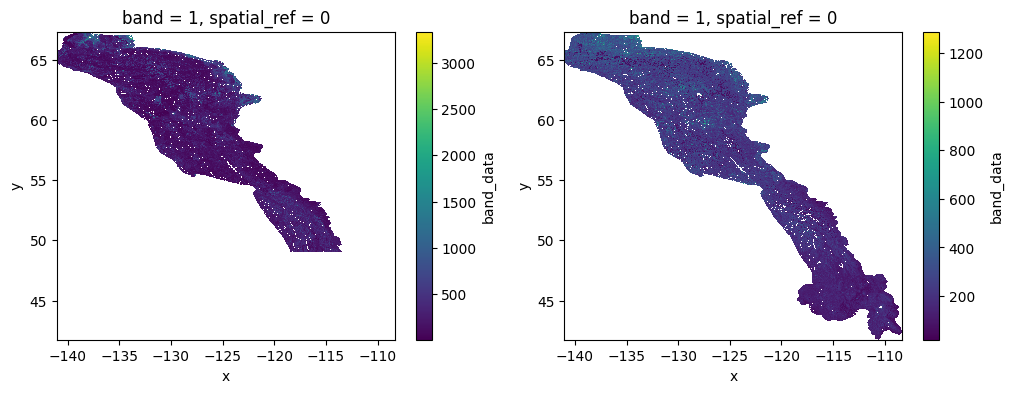

In [47]:
# # plot the two
# fig, axes = plt.subplots(ncols=2, figsize=(12,4))
# soc_sothe_reproj_t_ha.plot(ax=axes[0])
# soc_soilgrids_olm_0_100.plot(ax=axes[1])
# plt.draw()

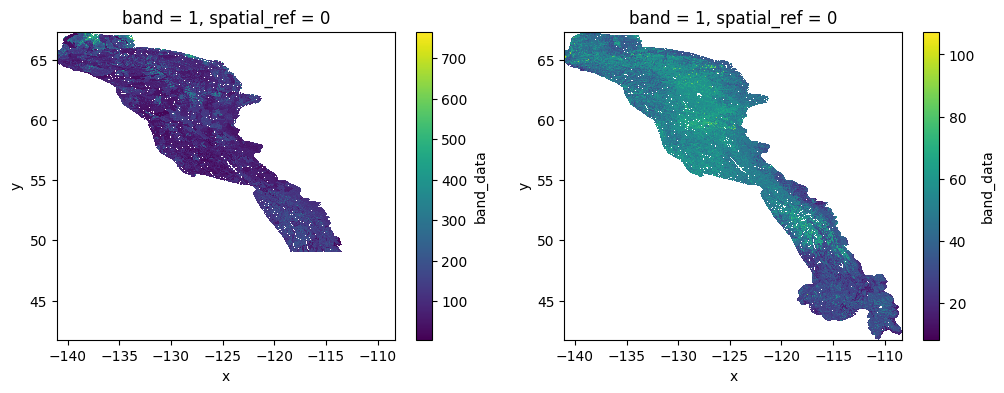

In [48]:
# # plot the two err layers
# fig, axes = plt.subplots(ncols=2, figsize=(12,4))
# soc_err_sothe_reproj_t_ha.plot(ax=axes[0])
# soc_err_soilgrids_0_30_reproj.plot(ax=axes[1])
# plt.draw()

In [30]:
# combine datasets, defaulting to Sothe values
soc_0_1m_t_ha = soc_sothe_reproj_t_ha.combine_first(soc_soilgrids_olm_0_100)
soc_0_1m_t_ha.rio.write_nodata(np.nan, encoded=True, inplace=True)

# # skip outputting error layer for soil since we don't have the full error data to support it
# soc_err_0_1m_t_ha = soc_err_sothe_reproj_t_ha.combine_first(soc_err_soilgrids_0_30_reproj)
# soc_err_0_1m_t_ha.rio.write_nodata(np.nan, encoded=True, inplace=True)

print_raster(soc_0_1m_t_ha)

shape: (9206, 11785)
resolution: (0.002777777777777999, -0.002777777777778)
bounds: (-141.03611111111087, 41.750000000000064, -108.29999999999715, 67.32222222222433)
sum: 5753467904.0
CRS: EPSG:4326
NoDataValue: nan
NoDataOriginalValues: nan



In [31]:
# round values to one decimal
soc_0_1m_t_ha = soc_0_1m_t_ha.round(1)

# write no data values into metadata
soc_0_1m_t_ha.rio.write_nodata(-9999, encoded=True, inplace=True)

print_raster(soc_0_1m_t_ha)

shape: (9206, 11785)
resolution: (0.002777777777777999, -0.002777777777778)
bounds: (-141.03611111111087, 41.750000000000064, -108.29999999999715, 67.32222222222433)
sum: 5753465856.0
CRS: EPSG:4326
NoDataValue: nan
NoDataOriginalValues: -9999.0



In [33]:
# export rasters
soc_0_1m_t_ha.rio.to_raster('./carbon_stock_data/output_layers/soc_0_1m_t_ha.tif')